## Multidimensional Attack Path Analysis

### John O'Neil

**Chief Data Scientist** <br/>
**Edgewise Networks** <br/>
**November 3, 2018**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/oneil/git/multidimensional-attack-path-demo')
import Graph
import NetworkData
from random import random, sample, choice
from math import sqrt, ceil

### Introduction

In this notebook, we'll be looking at how to combine:

* **NMAP** data (which reveals network topology)
* **Graph** algorithms (to find interesting paths through the network data)
* **Vulnerability** data (to determine which paths are the most vulnerable)

We'll see how to combine this into a view of a network that highlights the most likely paths of attack.

### Network Data

We've created the NMAP data previously, since it's considered hostile to run that sort of tool on someone else's network ;)

Abstractly, the NMAP data consists of tuples: **(source_ip, dest_ip, dest_port, service)**

### This is what NMAP output looks like

```
IP range,Port range,Protocols,DNS,Specific DNS servers,MAC,OS,
10.10.22.0/24; 10.10.21.0/24,1-11000,TCP,true,from local machine settings,true,true,

Scan Results,
IP,hostname,MAC,OS,Ping,Opened Ports,Closed ports,Filtered ports,
10.10.21.16,,,Windows Server 2008 R2 Datacenter 7601 Service Pack 1 ,0 ms,7,10993,,
Ports,Status,IANA name,
TCP/135,Open,epmap,
TCP/139,Open,netbios-ssn,
TCP/445,Open,microsoft-ds,
TCP/3306,Open,mysql,
TCP/3389,Open,ms-wbt-server,
TCP/5985,Open,wsman,
TCP/5986,Open,wsmans,
```

### First Demo

For our first demo, let's dip our toe in the water of graphs.

1. First, we get a small **graph**. This includes which nodes are internet-facing. It's created from the NMAP data.

1. Then we **select an IP address** which we're interested in.

1. Then, we look for the **shortest paths** from the selected node to the internet (i.e. to the internet-facing nodes).

Note that, to start with, the difficulty of getting from any node to any other is **the same**.

In [2]:
g, vulns, target = NetworkData.getSmallGraph(0.3)
print("target =", target)

target = 10.10.22.228


### Finding Paths

* From an **internet-accessible** periphery node to the **target**
* How to return paths:
  * $N$ shortest or most vulnerable paths — for example, $N = 3$
  * All paths with distance/vulnerability score less than or equal to $D$ — for example, $D\leq3$
* Several search techniques are possible
  * Dijkstra and A*
  * Beam search

### Best Path

Most algorithms are designed to find an extremal path (shortest or *best*)

### Beam Search

* Finds multiple "best paths"
* Each one has close to an extremal score.
* Uses dynamic programming so it's not too slow.

In [16]:
weightPathList = g.getShortestPathsByDistance(target, 5)
print(weightPathList)

[(2, ['10.10.22.26', '10.10.22.84', '10.10.22.228']), (2, ['10.10.22.38', '10.10.22.196', '10.10.22.228']), (3, ['10.10.21.104', '10.10.21.22', '10.10.22.84', '10.10.22.228']), (3, ['10.10.22.33', '10.10.22.153', '10.10.22.196', '10.10.22.228'])]


### Defining the Periphery

**Periphery** and **target** chosen using **eigenvector centrality**.

* The **most central** node is the **target**.
* The `ceil(sqrt(graph.size()))` **least central** nodes are peripheral.

### Both A Picture and 1000 Words >> Two Pictures or 2000 Words

Let's draw the shortest paths in the graph.

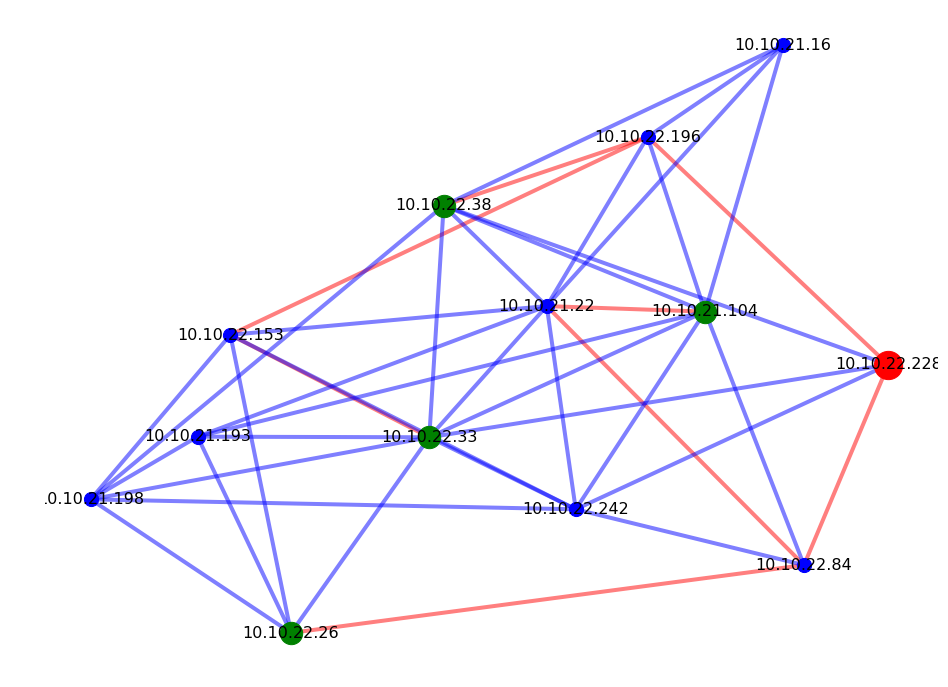

In [4]:
g.drawGraph(target, weightPathList)

### From Equal Weights to Vulnerability Data

* Sources of vulnerability (or malware) data
  * Commercial sources (e.g. Rapid7, Tenable, Qualys)
  * Free sources
* Incorporate into network data
* What vulnerability data changes

### Vulnerability Data in Action

The **vulnerabilities** are extracted from the NVD Vulnerability Database.

*Advantages*:
* Open-source
* Community-created
* Comprehensive

*Disadvantages*:
* Complex data structure
* `<sarcasm>`Not optimized for search`</sarcasm>`

Basically, it's a set of enormous XML (or JSON) files. Each file contains $\approx$ 50 MB of stuff like this:

![CVE sample](cve2.png)

### We're putting the (Elastic) Band Back Together

So, we ingested (the relevant parts of) the NVD data into **elasticsearch**.

This allows us to search for vulnerability information based on the **name** of the service listening on every open port.

### From Shortest to Most Vulnerable

So, time to apply the vulnerability data to the graph we created earlier.

Then, we can re-run the shortest path calculation and observe the differences.

In [18]:
gVuln = g.makeVulnerabilityGraph(vulns)

In [21]:
vulnWeightPathList = gVuln.getShortestPathsByDistance(target, 6.0)
print(vulnWeightPathList)

[(4.395328752206075, ['10.10.22.26', '10.10.22.84', '10.10.22.228']), (5.395328752206075, ['10.10.21.104', '10.10.21.22', '10.10.22.84', '10.10.22.228']), (5.395328752206075, ['10.10.22.33', '10.10.21.22', '10.10.22.84', '10.10.22.228']), (5.585291113381001, ['10.10.22.38', '10.10.22.196', '10.10.22.228'])]


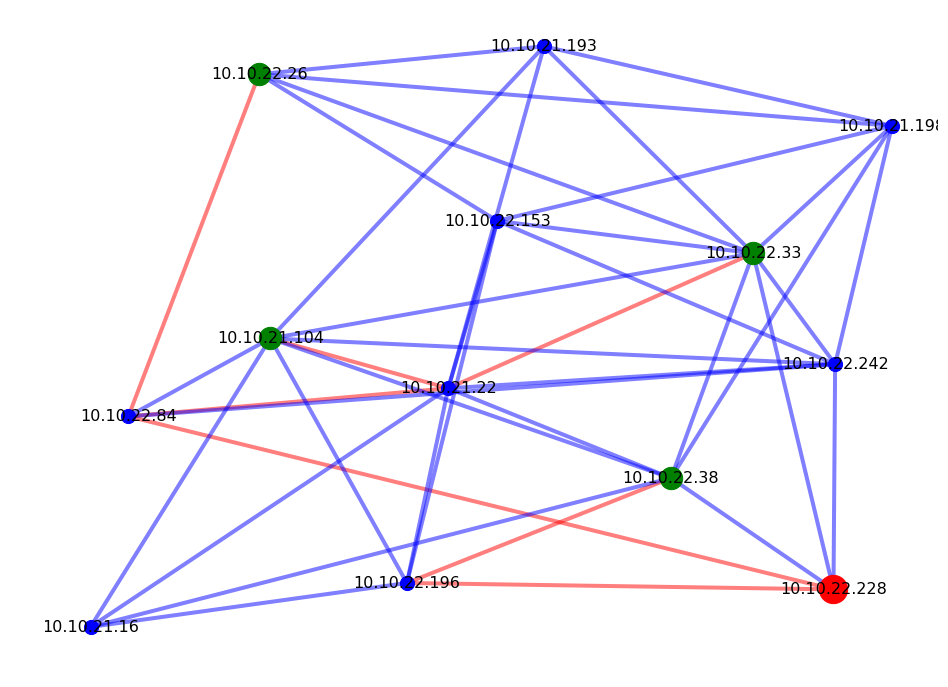

In [7]:
gVuln.drawGraph(target, vulnWeightPathList)

### Combining Vulnerabilities

The vulnerability of a host is the **harmonic mean** of the (inverse of the) known vulnerabilities of the open services on each host.

```python 
def harmonic(xs): return len(xs) / sum(1/x for x in xs) 
```

Note that in the NVD, vulnerabilities are between 1.0 (least vulnerable) and 10.0 (most vulnerable). Because we want more vulnerable == shorter distance, we're setting our vulnerabilities $=10/score$.

The **vulnerability** of a path from the internet to the target is the sum of the vulnerabilities of the hosts on the path.

In [8]:
vulns

{'10.10.21.16': 4.697986577181208,
 '10.10.21.22': 1.0,
 '10.10.21.104': 1.520912547528517,
 '10.10.21.193': 1.0,
 '10.10.21.198': 2.654084340902389,
 '10.10.22.26': 1.4285714285714284,
 '10.10.22.33': 1.1857707509881423,
 '10.10.22.38': 1.0,
 '10.10.22.84': 3.3044196612969845,
 '10.10.22.153': 1.1428571428571428,
 '10.10.22.196': 4.49438202247191,
 '10.10.22.228': 1.0909090909090908,
 '10.10.22.242': 1.3054830287206267}

### From Small Data to Big Data

Now we want to work with larger graphs. First, we create a **large** graph, and find the **shortest** paths from the internet-accessible hosts to the target.

In [9]:
G, Vulns, Target = NetworkData.getLargeGraph()
print("target =", target)

len(nodes) = 1313
len(edges) = 17106
target = 10.10.22.228


In [23]:
WeightPathList = G.getShortestPathsByDistance(Target, 3)
print(WeightPathList)

[(2, ['10.10.21.138', '10.10.23.29', '10.10.24.190']), (3, ['10.10.20.123', '10.10.24.118', '10.10.21.56', '10.10.24.190']), (3, ['10.10.20.18', '10.10.23.239', '10.10.24.224', '10.10.24.190']), (3, ['10.10.21.188', '10.10.20.223', '10.10.21.56', '10.10.24.190']), (3, ['10.10.22.225', '10.10.23.168', '10.10.23.29', '10.10.24.190']), (3, ['10.10.23.17', '10.10.24.110', '10.10.21.56', '10.10.24.190']), (3, ['10.10.23.181', '10.10.22.147', '10.10.24.224', '10.10.24.190']), (3, ['10.10.23.243', '10.10.23.239', '10.10.24.224', '10.10.24.190']), (3, ['10.10.23.62', '10.10.22.99', '10.10.23.29', '10.10.24.190']), (3, ['10.10.24.5', '10.10.25.36', '10.10.23.29', '10.10.24.190'])]


### On The Other Hand

**This** is what happens when you try to draw a graph that big.

![This is what happens when you try to draw a graph this large.](draw-large-graph.png)

### You Just Might Find You Get What You Need

* Draw only the shortest (or most vulnerable) paths. 
* We don't need to drown the critical information in irrelevant data.

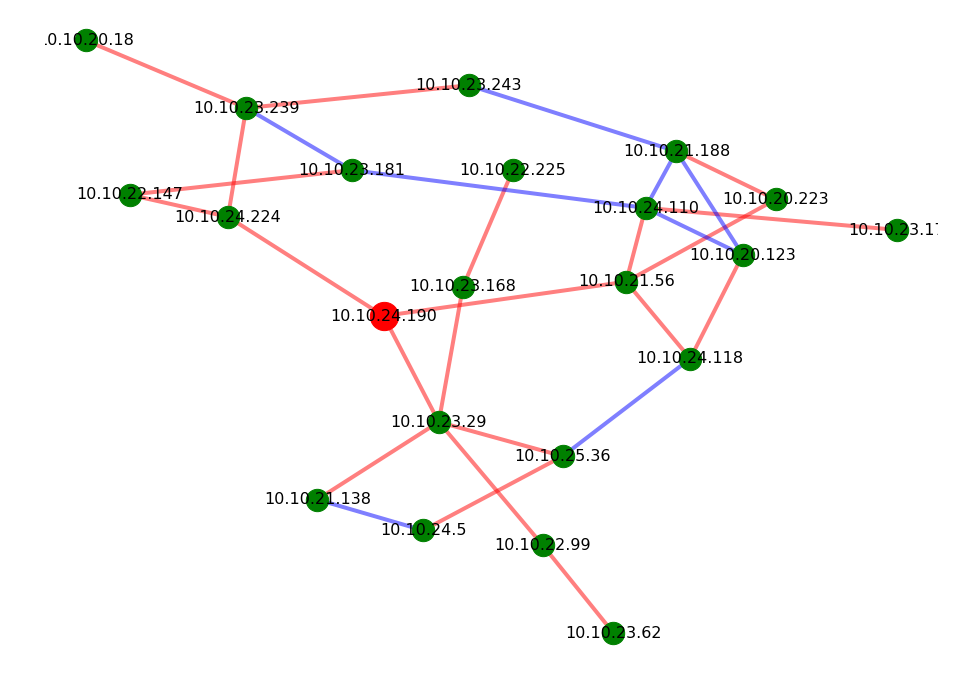

In [24]:
G.drawSparsePathGraph(Target, WeightPathList)

# Vulnerability in Large Graphs

Now we apply the vulnerability information to the large graph, and find the most vulnerable paths.

In [12]:
GVuln = G.makeVulnerabilityGraph(Vulns)

In [27]:
VulnWeightPathList = GVuln.getShortestPathsByDistance(Target, 4.0)
print(VulnWeightPathList)

[(3.062204383329263, ['10.10.21.138', '10.10.23.29', '10.10.24.190']), (3.89651603589804, ['10.10.20.18', '10.10.23.239', '10.10.24.224', '10.10.24.190']), (3.89651603589804, ['10.10.23.243', '10.10.23.239', '10.10.24.224', '10.10.24.190']), (3.9026153353675794, ['10.10.23.181', '10.10.22.147', '10.10.24.224', '10.10.24.190'])]


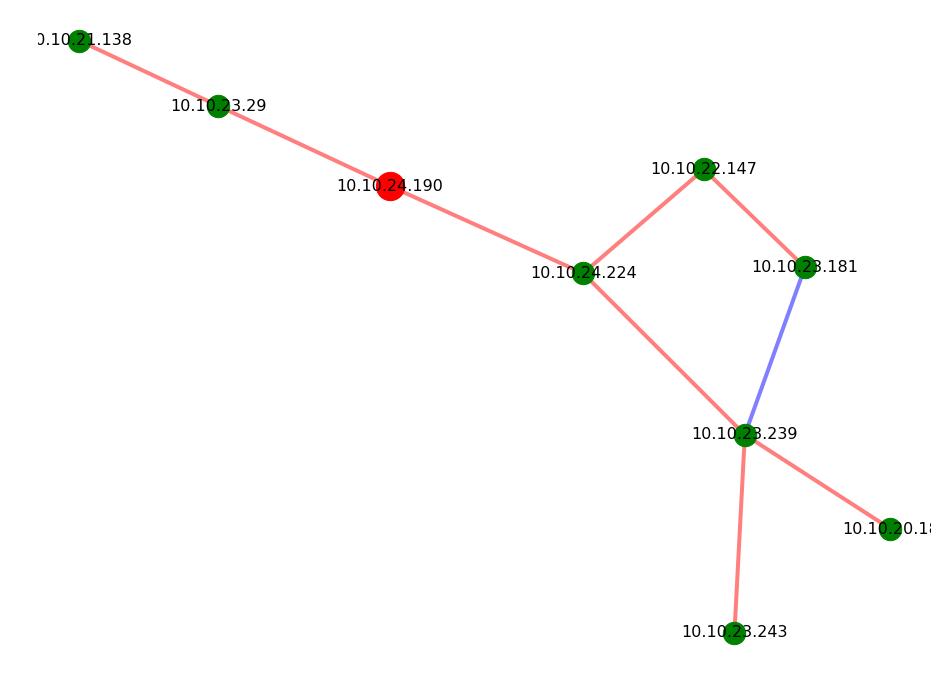

In [28]:
GVuln.drawSparsePathGraph(Target, VulnWeightPathList)

### Note on requirements.txt:

* Code in https://github.com/EdgewiseNetworks/multidimensional-attack-path-demo
* Needs Python :)
* Also `pip install {networkx, elasticsearch, matplotlib, jupyter}`
* Finally, you need to install **elasticsearch** (and **java** if necessary)

### And now back to our previously scheduled program.